# AIF_sprint11-12-nn-scratch

In [7]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline

## 活性化関数

### 活性化関数の説明

ニューラルネットワークにおける活性化関数とは入力信号の総和がどのように出力するか（**発火させる**という）を決定する関数です。
ポイントとなるのは関数が**非線形**であることで、線形関数の場合たとえば一層目が$y=ax$、二層目が$y=bx$ ならば$y=abx$の１層でよいので層を増やすメリットがありません。

非線形関数を用いることで層を増やすことで、線形変換では表現できなかったことが表現できるようになり、モデルの表現力を高めることができます、



### 活性化関数の実装

代表的な活性化関数は下記の４つが挙げられる。

1. ステップ関数
1. シグモイド関数
1. ReLU
1. tanh

それぞれグラフで描画しながら解説を行う。

### 1.ステップ関数

In [8]:
def step(z):
    a = z.copy()
    a[0<=a]=1
    a[a<0]=0
    return a

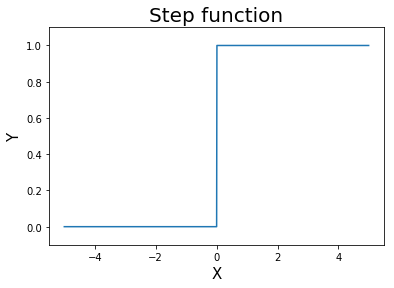

In [9]:
x = np.arange(-5,5,0.01)
y = step(x)

plt.plot(x,y)
plt.xlabel("X", fontsize=15)
plt.ylabel("Y", fontsize=15)
plt.title("Step function", fontsize=20)
plt.ylim(-0.1, 1.1)
plt.show()

**ステップ関数**は値がマイナスなら０、プラスなら１を返すシンプルな活性化関数です。

パーセプロトロンのように単純なモデルで使用されるが、微分値が０になってしまうためニューラルネットワーク以降では採用されない。

### 2.シグモイド関数

In [10]:
def sigmoid(z):
     return 1/(1+np.exp(-z))

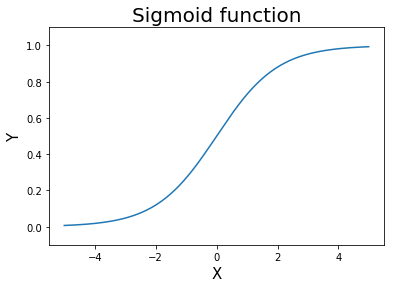

In [11]:
x = np.arange(-5,5,0.01)
y = sigmoid(x)

plt.plot(x,y)
plt.xlabel("X", fontsize=15)
plt.ylabel("Y", fontsize=15)
plt.title("Sigmoid function", fontsize=20)
plt.ylim(-0.1, 1.1)
plt.show()

ステップ関数と違い、なめらかで単調増加であり、微分が簡単なことから初期のニューラルネットワークで用いられた。
その他出力が0から１を返すことから、機械学習（分類問題）で確率を算出する際に使われる。

- ０にセンタリングされないため、勾配の更新方向が一定。
- 層を増やすことで勾配消失の恐れがある。
- 収束が遅い。

上記の理由によりディープニューラルネットワークでは後述するReLU関数

### 3.ReLU(ランプ関数)

In [12]:
def ReLU(z):
    a = z.copy()
    a[a<0]=0
    return a

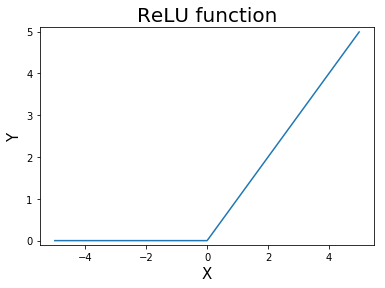

In [13]:
x = np.arange(-5,5,0.01)
y = ReLU(x)

plt.plot(x,y)
plt.xlabel("X", fontsize=15)
plt.ylabel("Y", fontsize=15)
plt.title("ReLU function", fontsize=20)
plt.ylim(-0.1, 5.1)
plt.show()

ここ数年のディープラーニングでメジャーな活性化関数が**ReLU関数です。**

負ならゼロ、正なら値をそのまま返すシンプルな関数ですが、後述するtanhより精度が高いことが分かり近年最もよく使われる。

- 実装がシンプルで早い。
- 0を作るため特徴量を絞り込める（スパース性）ため計算量が少ない。
- x>0では微分値が常に１であり勾配消失の心配はない。

### 4.tanh

In [14]:
def tanh(X):
    return np.tanh(X)

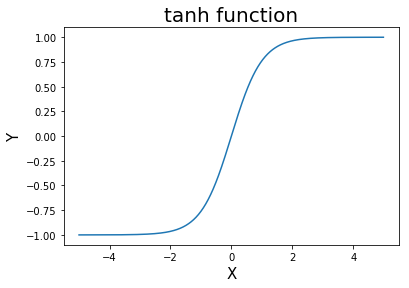

In [15]:
x = np.arange(-5,5,0.01)
y = tanh(x)

plt.plot(x,y)
plt.xlabel("X", fontsize=15)
plt.ylabel("Y", fontsize=15)
plt.title("tanh function", fontsize=20)
plt.ylim(-1.1, 1.1)
plt.show()

ゼロセンタリングされていることを除けば、シグモイド関数と同じ性質を持ちます。


### 今回のデータセットの生成と決定境界の描画関数の用意

今回はsklearnのデータセットからmake_moonsを用いる。

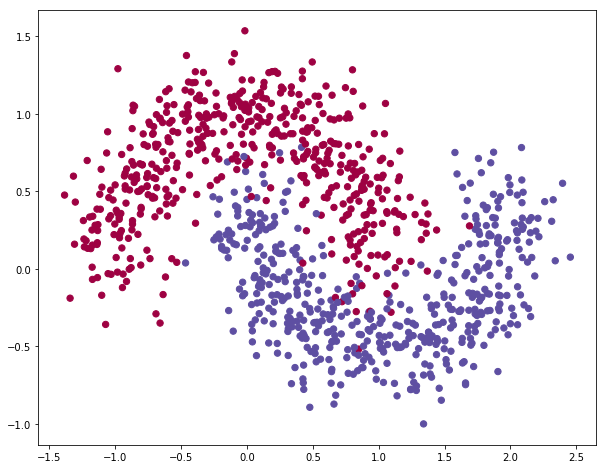

In [44]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)


# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()], params)
    # 予測値から予測したクラスに変換する
    Z = Z[: ,0]
    Z[Z>0.5] = 0
    Z[Z>0] = 1
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

# Generate a dataset and plot it
np.random.seed(0)
# X, y = sklearn.datasets.make_moons(200, noise=0.50)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)

plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

noiseを０にするときれいな半円を描き、数値を大きくするとデータが散らばっていく。

### yをonehot表現で表す。

y をone-hot表現に変更する関数を用意する。

In [17]:
def convert_onehot(y):
    y1 = y.copy()
    y1[y==0]=1
    y1[y==1]=0
    return np.array([y,y1]).T

## 出力層

### 出力関数（ソフトマックス関数）の実装

In [18]:
def softmax(X):
    return np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)

## フォワードプロパゲーション

学習済みパラメータを使って、入力データを受け取って一連の計算を行い、出力を出すことを
フォワードプロパゲーションと呼びます。

機械学習でいう予測（predict）にあたり、ニューラルネットワークでは推論処理とも呼びます。

### フォワードプロパゲーションの実装

今回は２層ニューラルネットワークの推論処理を実装する。
各計算手順は下記の通り。

$z_1 = xW_1 + b_1 $

$a_1 = tanh(z_1) $

$z_2 = a_1W_2 + b_2 $

$a_2 = \hat{y} = softmax(z_2)$

forward関数を作成し、predictという別名も与えておく。


In [19]:
# フォワードプロパゲーション
# つまりpredict?
def forward(X, params):
    z1 = np.dot(X, params['W1']) + params['b1']
    a1 = tanh(z1)
    z2 = np.dot(a1, params['W2']) + params['b2']
    y_pred = softmax(z2)
    
    return y_pred

predict = forward

## コスト関数

コスト関数には交差エントロピー誤差関数を用いる。

$L(y, \hat{y})
= -\frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i}\log \hat{y_{n, i}}$

### コスト関数の実装

In [20]:
def cost(y, y_pred, params, lam=0.01):
    data_size = y.shape[0]
    #  正則化項
    weight_sum = sum([np.sum(matrix**2) for key, matrix in params.items() if "W" in key])
    reg_term = (lam /2) * (weight_sum)
    # クロスエントロピー誤差関数　y_predは０になりえるので -inf にならないためにすごく小さい補正値を入れる
    cross_entorpy = -np.sum(y * np.log(y_pred + 1e-7))
    
    cost = (cross_entorpy + reg_term) / data_size
    return cost

In [21]:
# 正答率を算出する
def accuracy_score(X, y, params):
    y_pred =  predict(X, params)
    data_size = X.shape[0]
    score = np.sum([(y_pred * y)>=0.5]) / data_size
     
    return score

## バックプロパゲーション

### バックプロパゲーション関数の説明

バックプロパゲーション関数は予測値と実際の値の誤差を求め、
その誤差を最後の層から一番最初の層まで順番に勾配を求めることで数値微分をするより高速で勾配を求める関数。

### バックプロパゲーション関数のワークシート

手書きしたものを[ここ](https://github.com/kz23szk/diveintocode-term2/blob/master/sprint11-12/back_prop.jpg)にアップロードしています。

### 数値微分とバックプロパゲーション

勾配を求める方法として数値微分を用いる方法がある。
数値微分で勾配を求めパラメータを更新することも可能であるが計算コストが大きすぎるという欠点があり、より効率的に勾配を求めることができるバックプロパゲーションが用いられる。


### バックプロパゲーション関数の実装

$\delta_3 = \hat{y} -y$

$\delta_2 = (1 - \tanh{z_1}^2) \cdot \delta_3 W_2^T$

$\frac{\partial L}{\partial W_2} = a_1^T \delta_3$

$\frac{\partial L}{\partial b_2}  = \delta_3$

$\frac{\partial L}{\partial W_1} = x^T \delta_2$

$\frac{\partial L}{\partial b_1}  = \delta_2$

In [22]:
def backward(X, y, params):
    grads = {}
    # 必要な値を計算
    y_pred = predict(X, params)  
    z1 = X.dot(params['W1']) + params['b1']
    a1 = tanh(z1)
    delta3 = y_pred - y
    delta2 = (1 - a1 ** 2) * delta3.dot(params['W2'].T)
    
    grads['W2'] = a1.T.dot(delta3)
    grads['b2'] = delta3.sum(axis=0, keepdims=True)
    grads['W1'] = X.T.dot(delta2) 
    grads['b1'] = delta2.sum(axis=0, keepdims=True)
    
    return grads

In [23]:
# バックプロパゲーションを用いて勾配を求め、パラメータを更新する
def update(X, y, params, alpha=0.01, lam=0.1):
        
        grads = backward(X, y, params)
        
        params['W2'] -= alpha * (grads['W2'] + lam * params['W2'] )
        params['b2'] -= alpha * grads['b2']
        params['W1'] -= alpha * (grads['W1'] + lam * params['W1'] )
        params['b1'] -= alpha * grads['b1']

        return params

### 正則化の実装

コスト関数と上記の更新関数に正則化項を追加しています。

### 学習

- バッチ学習
    - 一回の更新にすべてのデータを使用する学習方法。すべてのデータを使うので精度が出やすい半面、過学習に陥りやすいのと学習に時間がかかる。
- ミニバッチ学習
    - 一回の更新に一部のデータを抽出して、使用する学習方法。バッチとオンラインの折衷案であり、サンプルデータ数によってバッチとオンラインどちらかの特性を切り替えられる。
- オンライン学習
    - 一回の更新にすべてのデータを使用する学習方法。学習コストが低く、データが更新されるような状況で使われるが、外れ値などのノイズを受けやすい。

### 最急降下法



In [24]:
from sklearn.model_selection import train_test_split

def gradient_descent(X, y, iteration=10000, alpha=0.001, lam=0.01, learning_mode=0, num_hidden_layer = 3):
    """
    learning mode 
    0: バッチ学習
    1:　ミニバッチ学習
    2:　オンライン学習
    """
    # 訓練とテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=0)
    y_train = convert_onehot(y_train)
    y_test = convert_onehot(y_test)

    # 分類クラス数を指定
    num_class = 2

    # パラメーターを一括で処理できるようにまとめる
    params = {
        'W1': np.random.randn(X_train.shape[1], num_hidden_layer) * 0.01,
        'b1': np.zeros([1, num_hidden_layer]),
        'W2': np.random.randn(num_hidden_layer, num_class) * 0.01,
        'b2': np.zeros([1, num_class])
    }

    past_costs = []
    past_accuracy = []
    
    valid_past_costs = []
    valid_past_accuracy = []
    
    # mini-batch size
    mini_batch_size = 20
    data_size = X_train.shape[0]
    if learning_mode == 0:
        batch_size = X_train.shape[0]
    elif learning_mode == 1:
        batch_size = mini_batch_size
    elif learning_mode == 2:
        batch_size = 1
    
    for i in range(iteration):
        # 学習に使用するデータをサンプリング
        choice_index = np.random.choice(data_size, batch_size)
        X_choice = X_train[choice_index]
        y_choice = y_train[choice_index]
        
        # その時点での正答率とコストを算出
        past_accuracy.append(accuracy_score(X_train, y_train, params))
        past_costs.append(cost(y_train, predict(X_train, params), params, lam))
        
        # テストデータのの正答率とコストを算出
        valid_past_accuracy.append(accuracy_score(X_test, y_test, params))
        valid_past_costs.append(cost(y_test, predict(X_test, params), params, lam))

        # 値の更新　backpropagationに基づく
        params = update(X_choice, y_choice, params, alpha, lam)
        
    return params, past_costs, past_accuracy, valid_past_costs, valid_past_accuracy

### 学習曲線のプロット

In [32]:
def plot_learning_curve(X, y, iterations, alpha, lam=0.01, metrics='cost', learning_mode=0, num_hidden_layer = 3): 
    
    _, past_costs, past_accuracy, valid_past_costs, valid_past_accuracy = gradient_descent(X, y, iterations, 
                                                                                                                                                                 alpha, lam, learning_mode,
                                                                                                                                                                  num_hidden_layer)
    plt.figure(figsize=(6,4))
    if metrics == 'cost':
        plt.plot(np.array(list(range(iterations))), np.array(past_costs), color='orange', label='train')
        plt.plot(np.array(list(range(iterations))), np.array(valid_past_costs), color='lime', label='test')
        plt.ylabel("cost", fontsize=15)
        print("last train cost is {}".format(past_costs[-1]))
        print("last test cost is {}".format(valid_past_costs[-1]))
    else:
        plt.plot(np.array(list(range(iterations))), np.array(past_accuracy), color='orange', label='train')
        plt.plot(np.array(list(range(iterations))), np.array(valid_past_accuracy), color='lime', label='test')
        plt.ylabel("accuracy", fontsize=15)
        print("last train accuracy is {}".format(past_accuracy[-1]))
        print("last test accuracy is {}".format(valid_past_accuracy[-1]))
        plt.ylim(-0.05, 1.05)
    
    plt.legend()
    plt.title('Learning Curve', fontsize=20)
    plt.xlabel("iteration", fontsize=15)
    

last train cost is 0.282756008771451
last test cost is 0.4037953325450084


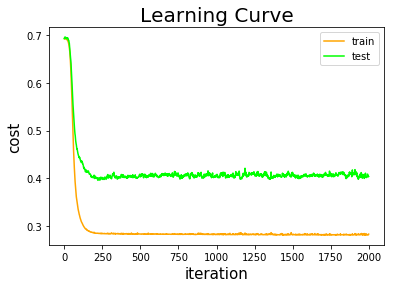

In [40]:
plot_learning_curve(X, y, 2000, 0.001, 0.1, 'cost', learning_mode=0, num_hidden_layer = 5)

last train cost is 0.08233050183621321
last test cost is 0.07278959035027022


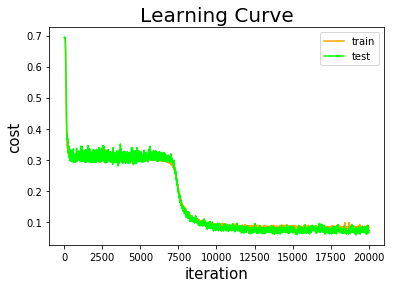

In [41]:
plot_learning_curve(X, y, 20000, 0.005, 0.01, 'cost', learning_mode=1, num_hidden_layer = 3)

last train cost is 0.34571602672018764
last test cost is 0.39873757975163937


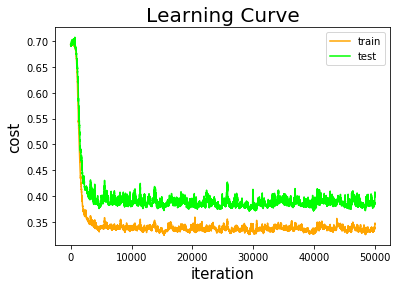

In [35]:
plot_learning_curve(X, y, 50000, 0.01, 0.05, 'cost', learning_mode=2, num_hidden_layer = 3)

last train accuracy is 0.8625
last test accuracy is 0.875


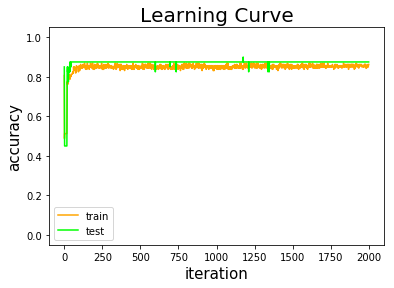

In [42]:
plot_learning_curve(X, y,2000, 0.002, 0.2, 'acc', learning_mode=0, num_hidden_layer = 3)

last train accuracy is 0.84375
last test accuracy is 0.8


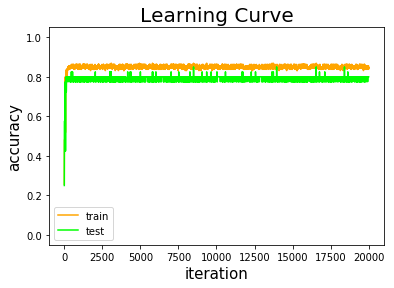

In [43]:
plot_learning_curve(X, y, 20000, 0.005, 1.5, 'acc', learning_mode=1, num_hidden_layer = 3)

last train accuracy is 0.875
last test accuracy is 0.775


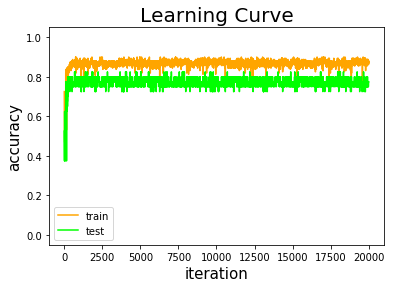

In [38]:
plot_learning_curve(X, y, 20000, 0.05, 0.01, 'acc', learning_mode=2, num_hidden_layer = 3)

### ハイパーパラメータ

#### ハイパーパラメータの初期化

それぞれのパラメータの適切な初期値について説明する。

- 隠れ層のユニット数
    - ユニット数を増やすと表現力が増すので小さい値（３あたり）からスタートし徐々に増やしていく。
- 学習率
    - 0.001あたりからスタートし、収束ぐあいを見て増減させていく。
- 正則化項
    - 0.001あたりからスタートし、過学習しているかをスコアから確認して過学習気味であれば大きくしていく。
    
 #### ハイパーパラメータチューニング
 
 単純にグリッドサーチを行い、検証データでの正答率が最も良いパラメータを探索する。

In [45]:
from sklearn.model_selection import train_test_split

def fit(X, y, iteration=10000, alpha=0.001, lam=0.01, learning_mode=0, num_hidden_layer = 3):
    """
    learning mode 
    0: バッチ学習
    1:　ミニバッチ学習
    2:　オンライン学習
    """
    
    y = convert_onehot(y)

    # 分類クラス数を指定
    num_class = 2

    # パラメーターを一括で処理できるようにまとめる
    params = {
        'W1': np.random.randn(X.shape[1], num_hidden_layer) * 0.01,
        'b1': np.zeros([1, num_hidden_layer]),
        'W2': np.random.randn(num_hidden_layer, num_class) * 0.01,
        'b2': np.zeros([1, num_class])
    }

    mini_batch_size = 20
    data_size = X.shape[0]
    if learning_mode == 0:
        batch_size = X.shape[0]
    elif learning_mode == 1:
        batch_size = mini_batch_size
    elif learning_mode == 2:
        batch_size = 1
    
    for i in range(iteration):
        # 学習に使用するデータをサンプリング
        choice_index = np.random.choice(data_size, batch_size)
        X_choice = X[choice_index]
        y_choice = y[choice_index]
        
        # 値の更新　backpropagationに基づく
        params = update(X_choice, y_choice, params, alpha, lam)
        
    return params

In [50]:
from sklearn.model_selection import KFold

range_num_hidden_layer = [3, 5, 10]
range_learning_rate = [0.001, 0.01]
range_reg_term_lambda = [0.001, 0.01]

for num_hidden_layer in range_num_hidden_layer:
    for learning_rate in range_learning_rate:
        for lam in range_reg_term_lambda:
            accuracy_list = []
            kf = KFold(n_splits=5, random_state=0)
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                params = fit(X_train, y_train, 10000, learning_rate, lam, 2, num_hidden_layer)
                y_test = convert_onehot(y_test)
                accuracy_list.append(accuracy_score(X_test, y_test, params))
            print('########')
            print('unit : {} lr : {}  reg_term : {} '.format(num_hidden_layer, learning_rate, lam))
            acc = np.array(accuracy_list)
            print("average : {} var: {}".format(round(np.mean(acc),3), round(np.var(acc),5)))
            
            print(' ')
            

########
unit : 3 lr : 0.001  reg_term : 0.001 
average : 0.809 var: 0.00061
 
########
unit : 3 lr : 0.001  reg_term : 0.01 
average : 0.814 var: 0.00059
 
########
unit : 3 lr : 0.01  reg_term : 0.001 
average : 0.861 var: 0.00031
 
########
unit : 3 lr : 0.01  reg_term : 0.01 
average : 0.861 var: 0.00045
 
########
unit : 5 lr : 0.001  reg_term : 0.001 
average : 0.806 var: 0.00079
 
########
unit : 5 lr : 0.001  reg_term : 0.01 
average : 0.8 var: 0.00061
 
########
unit : 5 lr : 0.01  reg_term : 0.001 
average : 0.863 var: 0.00041
 
########
unit : 5 lr : 0.01  reg_term : 0.01 
average : 0.866 var: 0.00058
 
########
unit : 10 lr : 0.001  reg_term : 0.001 
average : 0.809 var: 0.00046
 
########
unit : 10 lr : 0.001  reg_term : 0.01 
average : 0.81 var: 0.00053
 
########
unit : 10 lr : 0.01  reg_term : 0.001 
average : 0.857 var: 0.00039
 
########
unit : 10 lr : 0.01  reg_term : 0.01 
average : 0.863 var: 0.00034
 


今回は
ユニット数5、学習率0.01、正則化率 0.01がベストとなった。

本来ならばさらに範囲を絞って細かく見ていく必要がある。
average : 0.866 var: 0.00058

### 決定境界の実装

サンプルコードを今回作成したメソッドやデータ型に合わせ修正した。

決定境界は下記のように描画できる。

ユニット数10ではデータに沿った境界が引かれ、
ユニット数３では表現力が乏しく直線に近い境界が引かれる。

0.965

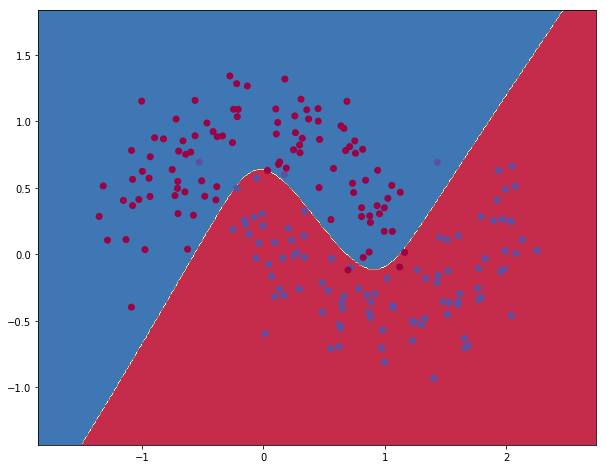

In [65]:
params = gradient_descent(X, y, iteration=20000, alpha=0.002, lam=0.01, learning_mode=1, num_hidden_layer = 10)[0]
plot_decision_boundary(predict)
accuracy_score(X, convert_onehot(y), params)

0.855

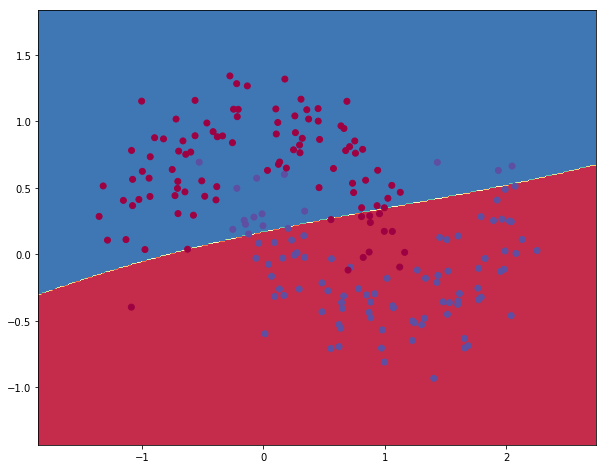

In [66]:
params = gradient_descent(X, y, iteration=20000, alpha=0.002, lam=0.01, learning_mode=1, num_hidden_layer = 3)[0]
plot_decision_boundary(predict)
accuracy_score(X, convert_onehot(y), params)